# XGBoost regressor

In [27]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import r2_score, mean_absolute_percentage_error, mean_absolute_error, mean_squared_error

from xgboost import XGBRegressor


from statsmodels.tools.eval_measures import stde




## Read the etl info results

In [28]:
df_info = pd.read_csv('../dataset_clean/options_csv_v1_etl.csv')
df_info

,remove_time_features,generic_features,remove_atypical_values,feature_combination,remove_feature_selection,remove_invalid_correlated_features
0,False,False,False,False,False,False


## Read the dataset

In [29]:
df = pd.read_csv('../dataset/V2_PlatteRiverWeir_features_merged_all.csv')
df

,Unnamed: 0.1,Unnamed: 0,SensorTime,CaptureTime,Filename,Agency,SiteNumber,TimeZone,Stage,Discharge,...,WwRawLineMin,WwRawLineMax,WwRawLineMean,WwRawLineSigma,WwCurveLineMin,WwCurveLineMax,WwCurveLineMean,WwCurveLineSigma,RiverArea,RiverWidth
0,0,0,2012-06-09 13:15:00,2012-06-09T13:09:07,statelineweir_20120609_farrell_001.jpg,USGS,6674500,MDT,2.99,916.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,49975.0,207.508733
1,1,1,2012-06-09 13:15:00,2012-06-09T13:10:29,statelineweir_20120609_farrell_002.jpg,USGS,6674500,MDT,2.99,916.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,50184.0,208.663145
2,2,2,2012-06-09 13:45:00,2012-06-09T13:44:01,statelineweir_20120609_farrell_003.jpg,USGS,6674500,MDT,2.96,873.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,50543.0,209.445067
3,3,3,2012-06-09 14:45:00,2012-06-09T14:44:30,statelineweir_20120609_farrell_004.jpg,USGS,6674500,MDT,2.94,846.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,50856.0,211.265690
4,4,4,2012-06-09 15:45:00,2012-06-09T15:44:59,statelineweir_20120609_farrell_005.jpg,USGS,6674500,MDT,2.94,846.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,51004.0,211.250274
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42054,42054,42054,2019-10-11 09:00:00,2019-10-11T08:59:53,statelineweir_20191011_farrell_409.jpg,USGS,6674500,MDT,2.54,434.0,...,9284.0,77521.0,38385.370066,15952.029728,0.0,70085.0,37550.894823,16444.401209,45842.0,194.934605
42055,42055,42055,2019-10-11 10:00:00,2019-10-11T09:59:52,statelineweir_20191011_farrell_410.jpg,USGS,6674500,MDT,2.54,434.0,...,10092.0,74614.0,40162.989292,15467.708856,0.0,70061.0,39397.339095,16009.008049,42300.0,194.762264
42056,42056,42056,2019-10-11 11:00:00,2019-10-11T10:59:52,statelineweir_20191011_farrell_411.jpg,USGS,6674500,MDT,2.54,434.0,...,7067.0,83260.0,42095.946590,16770.357949,0.0,76335.0,41350.006568,17489.374617,41080.0,196.480105
42057,42057,42057,2019-10-11 12:00:00,2019-10-11T11:59:53,statelineweir_20191011_farrell_412.jpg,USGS,6674500,MDT,2.54,434.0,...,6283.0,83045.0,45345.490954,17498.432849,0.0,78882.0,44553.920296,18268.294896,40976.0,193.595245


In [30]:
df['SensorTime'] = pd.to_datetime(df['SensorTime'])
df['Year'] = df['SensorTime'].dt.year
df['Month'] = df['SensorTime'].dt.month

In [31]:
df.dtypes

Unnamed: 0.1                 int64
Unnamed: 0                   int64
SensorTime          datetime64[ns]
CaptureTime                 object
Filename                    object
                         ...      
WwCurveLineSigma           float64
RiverArea                  float64
RiverWidth                 float64
Year                         int64
Month                        int64
Length: 65, dtype: object

In [32]:
df = df[df.Stage > 0]
df = df[df.Discharge > 0]

In [33]:

df.isna().sum()

Unnamed: 0.1        0
Unnamed: 0          0
SensorTime          0
CaptureTime         0
Filename            0
                   ..
WwCurveLineSigma    0
RiverArea           0
RiverWidth          0
Year                0
Month               0
Length: 65, dtype: int64

## Divide dataset to X and Y

In [34]:
df_train = df[(df.Year >= 2012) & (df.Year <= 2017)]
#df_val = df[(df.Year >= 2017) & (df.Year <= 2017)]
df_test = df[(df.Year >= 2018) & (df.Year <= 2019)]

In [35]:
df_train = df_train.drop(columns=["Year", "SensorTime", "CaptureTime"])
#df_val = df_val.drop(columns=["Year", "SensorTime", "CaptureTime"])
df_test = df_test.drop(columns=["Year", "SensorTime", "CaptureTime"])

In [36]:
np.random.seed(0)

y_train = df_train[["Stage"]]
X_train = df_train[["RiverWidth", "Month"]]

temp = list(zip(X_train.values, y_train.values))
np.random.shuffle(temp)
X_train, y_train = zip(*temp)
X_train, y_train = np.array(X_train), np.array(y_train)


y_test = df_test[["Stage"]].values
X_test = df_test[["RiverWidth", "Month"]].values

"""temp = list(zip(X_test.values, y_test.values))
np.random.shuffle(temp)
X_test, y_test = zip(*temp)
X_test, y_test = np.array(X_test), np.array(y_test)"""

'temp = list(zip(X_test.values, y_test.values))\nnp.random.shuffle(temp)\nX_test, y_test = zip(*temp)\nX_test, y_test = np.array(X_test), np.array(y_test)'

In [37]:
print(X_train.shape)
print(y_train.shape)

(27421, 2)
(27421, 1)


In [38]:
input_shape = X_train.shape[1]
output_shape = y_train.shape[1]

print(input_shape, output_shape)

2 1


## Train model

In [39]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', XGBRegressor(learning_rate = 0.001, max_depth=20, n_estimators = 1000, random_state=0, objective="reg:squaredlogerror"))
])

#param_grid = {'clf__hidden_layer_sizes': [(10), (10, 20), (10, 5, 15), (20, 30, 10, 15)], 'clf__alpha': np.arange(1e-3, 1, 0.001), 'clf__learning_rate_init': np.arange(1e-3, 0.1, 0.001), 'clf__activation': ['tanh', 'relu']}

param_grid = {'clf__alpha': np.arange(3, 6, 1)}

clf = RandomizedSearchCV(pipeline, param_distributions=param_grid, n_iter=30, n_jobs=8, verbose=3, scoring="neg_mean_squared_error")

In [40]:
clf.fit(X_train, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


/home/nkspartan/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/model_selection/_search.py:306: UserWarning: The total space of parameters 3 is smaller than n_iter=30. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[CV 1/5] END .....................clf__alpha=4;, score=-3.593 total time=   4.9s
[CV 1/5] END .....................clf__alpha=3;, score=-3.590 total time=   5.1s
[CV 5/5] END .....................clf__alpha=3;, score=-3.525 total time=   5.4s
[CV 3/5] END .....................clf__alpha=3;, score=-3.561 total time=   5.8s
[CV 4/5] END .....................clf__alpha=3;, score=-3.626 total time=   6.0s
[CV 3/5] END .....................clf__alpha=4;, score=-3.563 total time=   7.0s
[CV 2/5] END .....................clf__alpha=4;, score=-3.529 total time=   7.1s
[CV 2/5] END .....................clf__alpha=3;, score=-3.526 total time=   7.2s
[CV 4/5] END .....................clf__alpha=4;, score=-3.630 total time=   4.7s
[CV 5/5] END .....................clf__alpha=4;, score=-3.527 total time=   4.7s
[CV 1/5] END .....................clf__alpha=5;, score=-3.599 total time=   4.8s
[CV 2/5] END .....................clf__alpha=5;, score=-3.535 total time=   4.9s
[CV 3/5] END ...............

RandomizedSearchCV(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('clf',
                                              XGBRegressor(base_score=None,
                                                           booster=None,
                                                           callbacks=None,
                                                           colsample_bylevel=None,
                                                           colsample_bynode=None,
                                                           colsample_bytree=None,
                                                           early_stopping_rounds=None,
                                                           enable_categorical=False,
                                                           eval_metric=None,
                                                           feature_types=None,
                                                           gamma=None,
                                                           gpu_id=None,
                                                           grow_policy=None,
                                                           importance_type=No...
                                                           max_cat_to_onehot=None,
                                                           max_delta_step=None,
                                                           max_depth=20,
                                                           max_leaves=None,
                                                           min_child_weight=None,
                                                           missing=nan,
                                                           monotone_constraints=None,
                                                           n_estimators=1000,
                                                           n_jobs=None,
                                                           num_parallel_tree=None,
                                                           objective='reg:squaredlogerror',
                                                           predictor=None, ...))]),
                   n_iter=30, n_jobs=8,
                   param_distributions={'clf__alpha': array([3, 4, 5])},
                   scoring='neg_mean_squared_error', verbose=3)

## Test model

In [41]:
clf.best_score_

-3.5654478925375974

In [42]:
clf.best_params_

{'clf__alpha': 3}

In [43]:
clf.score(X_test, y_test)

-2.428866385901488

In [44]:
y_pred = clf.predict(X_test)

In [45]:
print("R^2: ", r2_score(y_test, y_pred))
print("mse: ", mean_squared_error(y_test, y_pred))
print("rmse: ", mean_squared_error(y_test, y_pred, squared=False))
print("mae: ", mean_absolute_error(y_test, y_pred))
print("mape: ", mean_absolute_percentage_error(y_test, y_pred))
print("Error estandar: ", stde(y_test.squeeze(),
      y_pred.squeeze(), ddof=2))


R^2:  -5.21926786039754
mse:  2.428866385901488
rmse:  1.5584820775040975
mae:  1.4566563900603402
mape:  0.5161999218232446
Error estandar:  0.5541360858006121


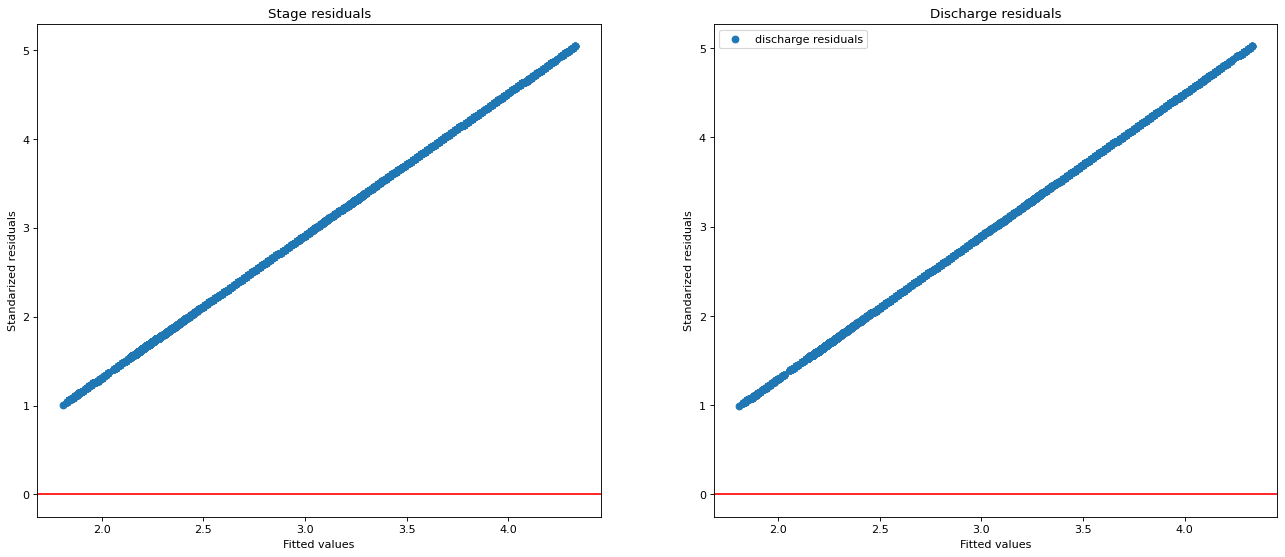

In [46]:
residuals = y_test - y_pred
residuals_std = residuals/residuals.std()

y_real_stage = np.array([i[0] for i in y_test])
residual_stage = np.array([i[0] for i in residuals])

y_real_discharge = np.array([i[-1] for i in y_test])
residual_discharge = np.array([i[-1] for i in residuals])


figure, ax = plt.subplots(ncols=2, figsize=(20, 8), dpi=80)

ax[0].scatter(y_real_stage, residual_stage / residual_stage.std(), label="stage residuals")
ax[1].scatter(y_real_discharge, residual_discharge / residual_discharge.std(), label="discharge residuals")
ax[0].axhline(y=0.0, color='r', linestyle='-')
ax[1].axhline(y=0.0, color='r', linestyle='-')

ax[0].set_title("Stage residuals")
ax[1].set_title("Discharge residuals")

ax[1].set_xlabel("Fitted values")
ax[0].set_xlabel("Fitted values")
ax[1].set_ylabel("Standarized residuals")
ax[0].set_ylabel("Standarized residuals")

plt.legend()
plt.show()

In [47]:
import statsmodels.api as sm
from statsmodels.stats.diagnostic import normal_ad

#figure = sm.qqplot(residual_stage / residual_stage.std(), line ='45', label='stage')
plt.show()

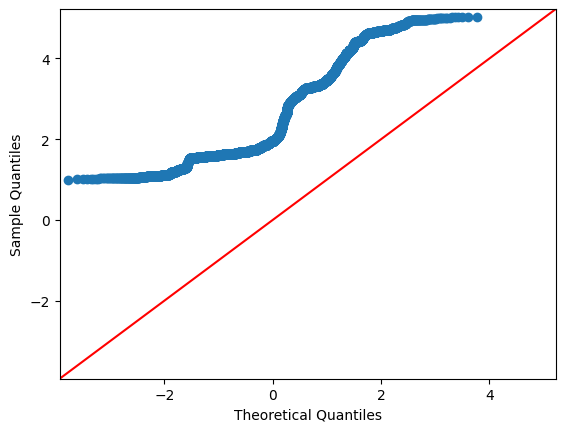

In [48]:
figure = sm.qqplot(residual_discharge / residual_discharge.std(), line='45', label='discharge')
plt.show()

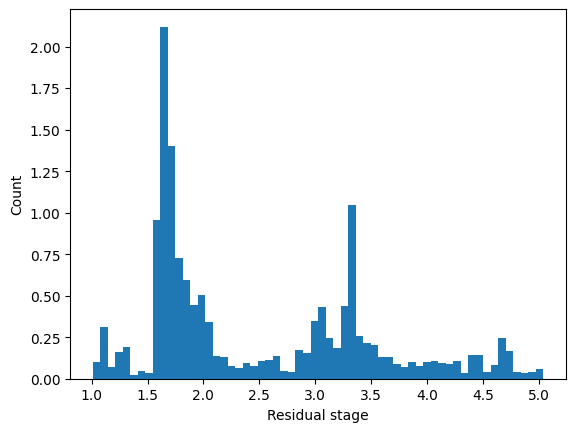

In [49]:
plt.hist(residual_stage / residual_stage.std(), density=True, bins = 60)
plt.ylabel('Count')
plt.xlabel('Residual stage');
plt.show()

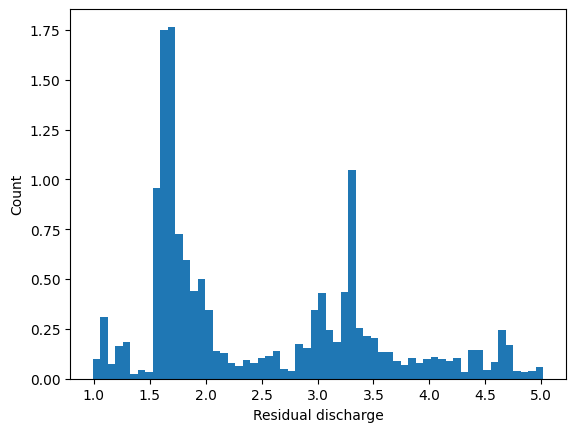

In [50]:
plt.hist(residual_discharge / residual_discharge.std(), density=True, bins = 60)
plt.ylabel('Count')
plt.xlabel('Residual discharge');
plt.show()

In [51]:
stat, pval = normal_ad(residual_discharge / residual_discharge.std())
print("p-value:", pval)

if pval < 0.05:
    print("Hay evidencia de que los residuos no provienen de una distribución normal.")
else:
    print("No hay evidencia para rechazar la hipótesis de que los residuos vienen de una distribución normal.")


p-value: 0.0
Hay evidencia de que los residuos no provienen de una distribución normal.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


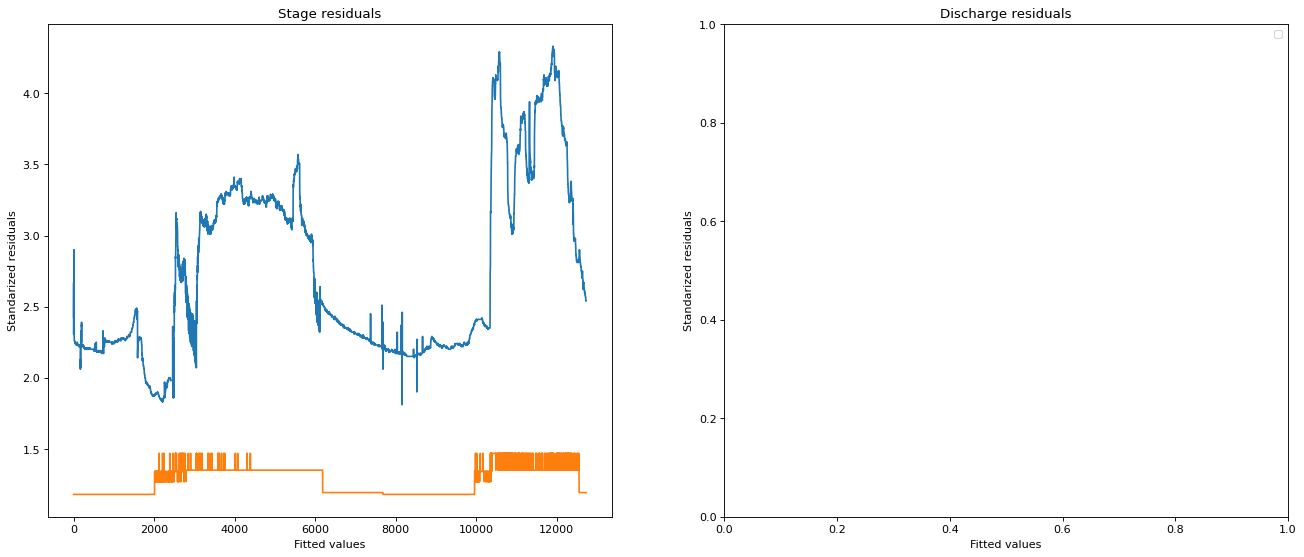

In [52]:
figure, ax = plt.subplots(ncols=2, figsize=(20, 8), dpi=80)

ax[0].plot(np.arange(len(y_test)), y_test, label="Stage real")
ax[0].plot(np.arange(len(y_test)), y_pred, label="Stage pred")

ax[0].set_title("Stage residuals")
ax[1].set_title("Discharge residuals")

ax[1].set_xlabel("Fitted values")
ax[0].set_xlabel("Fitted values")
ax[1].set_ylabel("Standarized residuals")
ax[0].set_ylabel("Standarized residuals")

plt.legend()
plt.show()